# Comparing machine learning approaches to predict SEEG accuracy

[![DOI](https://zenodo.org/badge/99125443.svg)](https://zenodo.org/badge/latestdoi/99125443)

Stereoencephalography (SEEG) is a technique used in drug-resistant epilepsy patients that may be a candidate for surgical resection of the epileptogenic zone. Multiple electrodes are placed using a so-called "frame based" stereotactic approach, in our case using the [Leksell frame](https://www.elekta.com/neurosurgery/leksell-stereotactic-system/). In our previous paper "[Methodology, outcome, safety and in vivo accuracy in traditional frame-based stereoelectroencephalography](https://www.ncbi.nlm.nih.gov/pubmed/28676892)" by Van der Loo et al (2017) we reported on SEEG electrode implantation accuracy in a cohort of 71 patients who were operated between September 2008 and April 2016, in whom a total of 902 electrodes were implanted. Data for in vivo application accuracy analysis were available for 866 electrodes.

The goal of the current project is to use a public version of this dataset (without any personal identifiers) to predict electrode implantation accuracy by using and comparing different machine learning approaches. 

[Pieter Kubben](http://dign.eu), MD, PhD<br/>
neurosurgeon @ [Maastricht University Medical Center](https://www.mumc.nl/en), The Netherlands

For any questions you can reach me by [email](mailto:p.kubben@mumc.nl) or on [Twitter](http://twitter.com/DigNeurosurgeon).

## Data description

The public dataset contains these variables:

- *PatientPosition*: patient position during surgery (nominal: supine, prone)
- *Contacts*: nr of contacts of electrode implanted (ordinal: 5, 8, 10, 12, 15, 18)
- *ElectrodeType*: describes trajectory type (nominal: oblique, orthogonal). Oblique refers to implantation using the Leksell arc, and orthogonal using a dedicated L-piece mounted on the frame (mostly implants in temporal lobe) when arc angles become too high (approx > 155&deg;) or too low (approx < 25&deg;)
- *PlanningX*: planned Cartesian X coord of target (numeric, in mm)
- *PlanningY*: planned Cartesian Y coord of target (numeric, in mm)
- *PlanningZ*: planned Cartesian Z coord of target (numeric, in mm)
- *PlanningRing*: planned ring coord, the trajectory direction in sagittal plane (numeric, in degrees); defines entry
- *PlanningArc*: planned arc coord (trajectory direction in coronal plane (numeric, in degrees); defines entry
- *DuraTipDistancePlanned*: distance from dura mater (outer sheet covering the brain surface) to target (numeric, in mm)
- *EntryX*: real Cartesian X coord of entry point (numeric, in mm)
- *EntryY*: real Cartesian Y coord of entry point (numeric, in mm)
- *EntryZ*: real Cartesian Z coord of entry point (numeric, in mm)
- *TipX*: real Cartesian X coord of target point (numeric, in mm)
- *TipY*: real Cartesian Y coord of target point (numeric, in mm)
- *TipZ*: real Cartesian Z coord of target point (numeric, in mm)
- *SkinSkullDistance*: distance between skin surfacce and skull surface (numeric, in mm)
- *SkullThickness*: skull thickness (numeric, in mm)
- *SkullAngle*: insertion angle of electrode relative to skull (numeric, in degrees)
- *ScrewLength*: length of bone screw used to guide and fixate electrode (ordinal: 20, 25, 30, 35 mm)

The electrodes are the [Microdeep depth electrodes](http://www.diximedical.com/en/microdeep-depth-electrode) by DIXI Medical.

To the limited extent possible in this case I tried to make these [FAIR data](https://www.nature.com/articles/sdata201618) and adhere to [FAIR guiding principles](https://www.nature.com/articles/sdata201618#bx2). In practice this meant I introduced the topic, described my data and created a [DOI](https://zenodo.org/badge/latestdoi/99125443).

Now let's get started.

In [1]:
# import libraries
import turicreate as tc
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
#%xmode plain; # shorter error messages
pd.options.mode.chained_assignment = None 
# global setting whether to save figures or not
# will save as 300 dpi PNG - all filenames start with "fig_"
save_figures = False

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load data
electrodes = pd.read_csv('electrodes_public.csv')

In [3]:
# find missing values
nan_rows = sum([True for idx,row in electrodes.iterrows() if any(row.isnull())])
print('Nr of rows with missing values:', nan_rows)

Nr of rows with missing values: 823


In [4]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table

In [5]:
missing_values_table(electrodes)

,Missing Values,% of Total Values
PatientPosition,0,0.000000
Contacts,56,6.466513
ElectrodeType,0,0.000000
PlanningX,0,0.000000
PlanningY,0,0.000000
PlanningZ,0,0.000000
PlanningRing,271,31.293303
PlanningArc,271,31.293303
DuraTipDistancePlanned,54,6.235566
EntryX,279,32.217090


In [6]:
#not used features
electrodes.drop(['EntryX', 'EntryY', 'EntryZ','ScrewLength','PlanningRing','PlanningArc'], axis = 1, inplace = True)

In [7]:
# calculate TPLE and remove entry data from dataframe
electrodes['TPLE'] = np.sqrt(np.square(electrodes['TipX'] - electrodes['PlanningX']) + 
                              np.square(electrodes['TipY'] - electrodes['PlanningY']) + 
                              np.square(electrodes['TipZ'] - electrodes['PlanningZ'])
                             ).round(1)

In [8]:
#plt.figure(figsize=[16, 8])
#sns.distplot(electrodes['TPLE'], hist=False, rug=True)
#sns.distplot(electrodes['TPLE'])

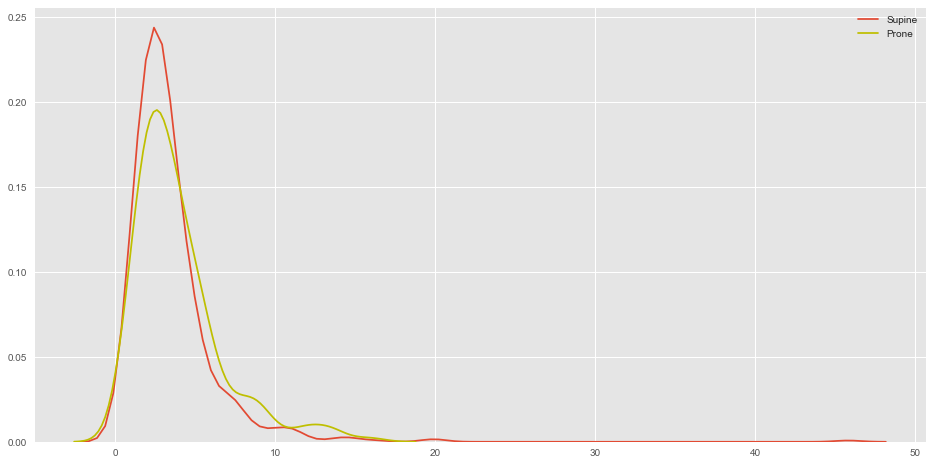

In [9]:
plt.figure(figsize=[16, 8])
sns.kdeplot(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'], label='Supine')
sns.kdeplot(electrodes[electrodes['PatientPosition']=='Prone']['TPLE'], label='Prone',  color='y')

It looks like their distributions come from different samples

In [10]:
print('TPLE Mean Supine: {} (SD {}) \nTPLE Mean Prone: {} (SD {})'.format(
    round(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'].mean(),2), round(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'].std(),2), 
    round(electrodes[electrodes['PatientPosition']=='Prone']['TPLE'].mean(),2), round(electrodes[electrodes['PatientPosition']=='Prone']['TPLE'].std(),2))) 

TPLE Mean Supine: 3.45 (SD 2.88) 
TPLE Mean Prone: 3.92 (SD 2.75)


Let's prove if indeed are independet samples with a t-test. If we observe a large p-value, then we cannot reject the null hypothesis of identical means. If the p-value is smaller than alpha, then we reject the null hypothesis of equal means.

In [11]:
alpha = 0.05
t_stat, p = stats.mstats.ttest_ind(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'],
                                   electrodes[electrodes['PatientPosition']=='Prone']['TPLE'])
if p < alpha: 
    print("p= {} The null hypothesis can be rejected".format(p))
else:
    print("p= {} The null hypothesis cannot be rejected".format(p))

p= 0.04187565196970924 The null hypothesis can be rejected


So it means the two groups came from diferent populations, and we might trate them different

We do the same with electrode type

In [12]:
print('TPLE Mean Oblique: {} (SD {}) \nTPLE Mean Orthogonal: {} (SD {})'.format(
    round(electrodes[electrodes['ElectrodeType']=='Oblique']['TPLE'].mean(),2), round(electrodes[electrodes['ElectrodeType']=='Oblique']['TPLE'].std(),2), 
    round(electrodes[electrodes['ElectrodeType']=='Orthogonal']['TPLE'].mean(),2), round(electrodes[electrodes['ElectrodeType']=='Orthogonal']['TPLE'].std(),2))) 

TPLE Mean Oblique: 3.44 (SD 2.93) 
TPLE Mean Orthogonal: 3.81 (SD 2.68)


Computing t-test.

In [13]:
alpha = 0.05
t_stat, p = stats.mstats.ttest_ind(electrodes[electrodes['ElectrodeType']=='Oblique']['TPLE'],
                                   electrodes[electrodes['ElectrodeType']=='Orthogonal']['TPLE'])
if p < alpha: 
    print("p= {} The null hypothesis can be rejected".format(p))
else:
    print("p= {} The null hypothesis cannot be rejected".format(p))

p= 0.07447724453227494 The null hypothesis cannot be rejected


In [14]:
#missing_values_table(electrodes)

In [15]:
#taking into account came from different distributions
df_supine = electrodes[electrodes['PatientPosition']=='Supine']
df_prone = electrodes[electrodes['PatientPosition']=='Prone']

### Input missing variables

We start with the variable to input DuraTipDistancePlanned, but first take a look to the distribution

In [16]:
dura_sup = df_supine['DuraTipDistancePlanned'].dropna()
dura_pro = df_prone['DuraTipDistancePlanned'].dropna()

In [17]:
# normallity test
def normal_test(vector, alpha = 0.05):
    k2, p = stats.mstats.normaltest(vector)
    if p < alpha: # null hypothesis: x comes from a normal distribution
        print("p = {} The null hypothesis can be rejected".format(p))
    else: 
        print("p = {} The null hypothesis cannot be rejected".format(p))

p = 5.988057054136884e-17 The null hypothesis can be rejected
p = 0.0005791646181393273 The null hypothesis can be rejected


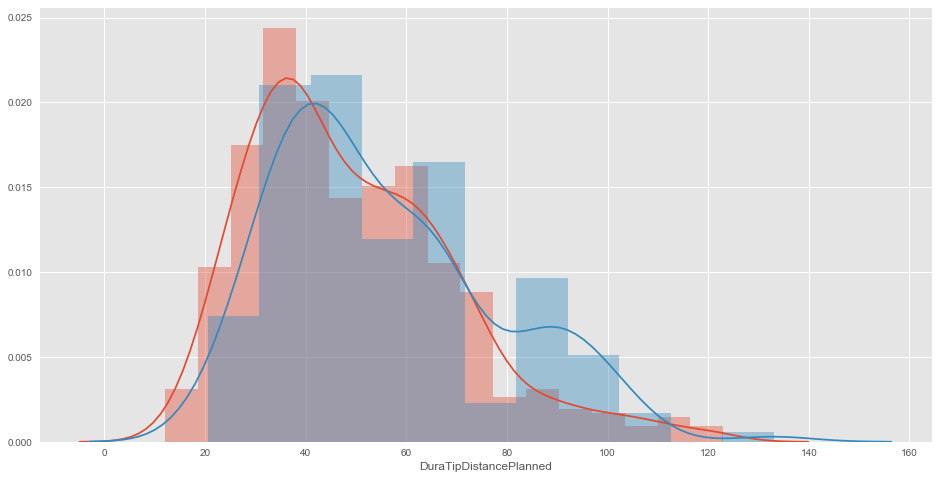

In [18]:
#electrodes['DuraTipDistancePlanned'].hist()
plt.figure(figsize=[16, 8])
sns.distplot(dura_sup)
sns.distplot(dura_pro)
normal_test(dura_sup)
normal_test(dura_pro)

They are normal distribuited so we might input variables with the statistics of the variable

In [19]:
def input_mean(df, variable):
    df_null = df[df[variable].isnull()]
    df_not_null = df[df[variable].notnull()]
    df_null[variable] = round(df_not_null[variable].mean(),1)
    inputed_df = df_null.append(df_not_null).sort_index()
    return inputed_df

In [20]:
df_supine = input_mean(df_supine, 'DuraTipDistancePlanned')

In [21]:
df_prone = input_mean(df_prone, 'DuraTipDistancePlanned')

We merge again

In [22]:
electrodes = df_supine.append(df_prone).sort_index()

In [23]:
#missing_values_table(electrodes)

Next variable to input is the number of contacts

In [24]:
#electrodes.insert(0, 'Index', electrodes.index)

In [25]:
contact_null = electrodes[electrodes['Contacts'].isnull()]
contact_not_null = electrodes[electrodes['Contacts'].notnull()]

In [26]:
contact_not_null['Contacts'] = contact_not_null['Contacts'].astype(int)

We need to convert into sframe

In [27]:
sf_contact_not_null = tc.SFrame(data=contact_not_null)

In [28]:
# features for contacts classifier
features = ['PatientPosition', 'ElectrodeType', 'PlanningX', 'PlanningY', 'PlanningZ', 'DuraTipDistancePlanned', 'SkinSkullDistance', 'SkullThickness', 'SkullAngle']

In [29]:
# We train a classifier
train_data, test_data = sf_contact_not_null.random_split(0.85)

clf1 = tc.classifier.create(train_data, target='Contacts', features = features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 657

Number of classes           : 6

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.025693     | 0.824962          | 0.736842            | 1.316644          | 1.341027            |

| 2         | 0.045652     | 0.843227          | 0.789474            | 1.061664          | 1.126348            |

| 3         | 0.062820     | 0.869102          | 0.789474            | 0.879626          | 0.977299            |

| 4         | 0.084488     | 0.887367          | 0.789474            | 0.735525          | 0.887165            |

| 5         | 0.101786     | 0.905632          | 0.842105            | 0.624163          | 0.793121            |

| 6         | 0.119630     | 0.917808          | 0.789474            | 0.547625          | 0.754650            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 657

Number of classes           : 6

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.020547     | 0.791476          | 0.631579            | 0.823659          | 1.154322            |

| 2         | 0.033023     | 0.838661          | 0.789474            | 0.787766          | 0.991846            |

| 3         | 0.043080     | 0.815830          | 0.736842            | 0.755546          | 0.914248            |

| 4         | 0.052007     | 0.846271          | 0.684211            | 0.758606          | 0.972837            |

| 5         | 0.062435     | 0.849315          | 0.684211            | 0.755760          | 0.948900            |

| 6         | 0.075902     | 0.861492          | 0.684211            | 0.753485          | 0.957275            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 657

Number of classes           : 6

Number of feature columns   : 9

Number of unpacked features : 9

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.020087     | 0.824962          | 0.736842            | 0.680823          | 0.748151            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 657

Number of classes           : 6

Number of feature columns   : 9

Number of unpacked features : 9

Number of coefficients      : 50

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.005701     | 0.496195          | 0.578947            |

| 2         | 3        | 0.011538     | 0.531202          | 0.684211            |

| 3         | 4        | 0.015876     | 0.560122          | 0.684211            |

| 4         | 5        | 0.019750     | 0.564688          | 0.684211            |

| 5         | 6        | 0.023951     | 0.563166          | 0.684211            |

| 6         | 7        | 0.027471     | 0.563166          | 0.684211            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.7894736528396606
PROGRESS: RandomForestClassifier          : 0.7368420958518982
PROGRESS: DecisionTreeClassifier          : 0.7368420958518982
PROGRESS: LogisticClassifier              : 0.684211
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [30]:
clf1

Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 657
Number of feature columns      : 9
Number of unpacked features    : 9
Number of classes              : 6

Settings
--------
Number of trees                : 60
Max tree depth                 : 6
Training time (sec)            : 0.1743
Training accuracy              : 0.9589
Validation accuracy            : 0.7895
Training log_loss              : 0.3432
Validation log_loss            : 0.663

In [31]:
#clf1.evaluate(test_data)
#clf1.evaluate(train_data)

In [32]:
#now convert the rest of the data
sf_contact_null = tc.SFrame(data=contact_null)

In [33]:
new_contacts = clf1.predict(sf_contact_null[features])

In [34]:
contact_null['Contacts'] = new_contacts

New electrodes table with inputed values

In [35]:
electrodes = contact_null.append(contact_not_null).sort_index()

In [36]:
#missing_values_table(electrodes)

How the categories look like on the two different groups?

In [37]:
contacts_supine = df_supine.groupby('Contacts').count()['TPLE']
contacts_prone = df_prone.groupby('Contacts').count()['TPLE']

<BarContainer object of 6 artists>

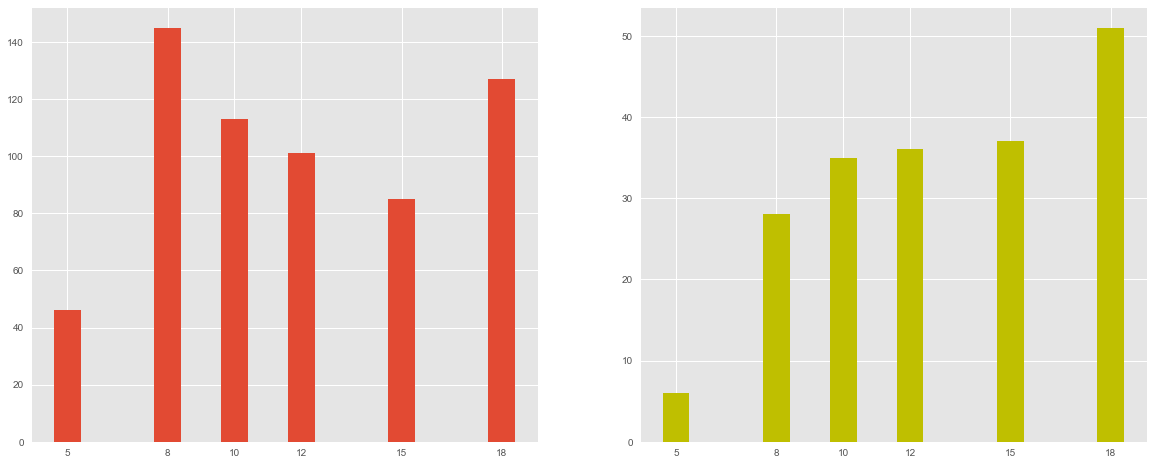

In [38]:
plt.figure(figsize=[20, 8])
plt.subplot(1,2,1); plt.xticks(contacts_supine.index)
plt.bar(contacts_supine.index, contacts_supine)
plt.subplot(1,2,2), plt.xticks(contacts_prone.index)
plt.bar(contacts_prone.index, contacts_prone, color='y')

### Target Variables

Now we will remove large outliers (difference between planned and real coord) in the Z-axis as electrode insertion length (depth) is influenced also by other factors (calculations regarding depth which could lead to either too superficial or too deep, but also possible malfixation of the screw cap which may cause loosening of the electrode and hence a more superficial position.. it won't migrate into the depth spontaneously). These are very limited numbers and would too much influence further analysis.

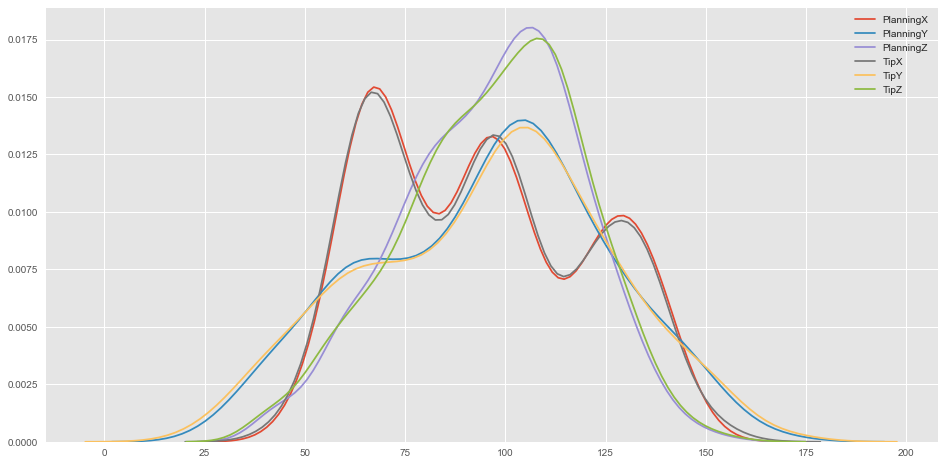

In [39]:
plt.figure(figsize=[16, 8])
coordinates = ['PlanningX','PlanningY','PlanningZ','TipX','TipY','TipZ']
for c in coordinates:
    sns.kdeplot(electrodes[str(c)], label=str(c))

Every Axis follows a particular distribution, let's try a normal test

In [40]:
for c in coordinates:
    normal_test(electrodes[str(c)])

p = 6.9465819854989e-84 The null hypothesis can be rejected
p = 1.882265752281482e-07 The null hypothesis can be rejected
p = 0.0002928270371526327 The null hypothesis can be rejected
p = 1.404931961375195e-62 The null hypothesis can be rejected
p = 1.9081660369783106e-06 The null hypothesis can be rejected
p = 0.00010052998936429912 The null hypothesis can be rejected


Not normal distribuited

In [41]:
electrodes.head()

,PatientPosition,Contacts,ElectrodeType,PlanningX,PlanningY,PlanningZ,DuraTipDistancePlanned,TipX,TipY,TipZ,SkinSkullDistance,SkullThickness,SkullAngle,TPLE
0,Supine,18,Oblique,125.8,106.5,135.5,86.6,126.4,106.8,135.2,7.0,9.7,70.3,0.7
1,Supine,18,Oblique,130.6,131.0,136.4,105.9,134.7,132.9,136.0,9.4,7.4,63.8,4.5
2,Supine,10,Oblique,139.1,104.9,124.0,35.2,139.1,108.3,124.4,9.8,5.5,66.4,3.4
3,Supine,10,Oblique,137.7,112.2,115.0,35.9,136.4,115.2,115.0,8.4,6.5,66.3,3.3
4,Supine,12,Oblique,126.0,76.0,124.1,39.5,124.6,75.8,126.8,7.4,4.6,84.7,3.0


We need to structure our data properly for further analysis and convert the categorical variables (nominal, ordinal) to the `category` type.

In [42]:
# convert categorical columns to "category" dtype
#catcols = ['PatientPosition', 'Contacts', 'ElectrodeType', 'ScrewLength']
#for cat in catcols:
#    electrodes[cat] = electrodes[cat].astype('category')

# confirm correct types for all columns now
#electrodes.dtypes

### Regression Model

In [43]:
electrodes.drop('TPLE', axis = 1, inplace = True)

In [44]:
#electrodes.insert(0, 'Index', range(0, len(electrodes), 1))
sf_electrodes = tc.SFrame(data=electrodes)

In [45]:
sf_electrodes.head()

PatientPosition,Contacts,ElectrodeType,PlanningX,PlanningY,PlanningZ,DuraTipDistancePlanned,TipX
Supine,18,Oblique,125.8,106.5,135.5,86.6,126.4
Supine,18,Oblique,130.6,131.0,136.4,105.9,134.7
Supine,10,Oblique,139.1,104.9,124.0,35.2,139.1
Supine,10,Oblique,137.7,112.2,115.0,35.9,136.4
Supine,12,Oblique,126.0,76.0,124.1,39.5,124.6
Supine,15,Oblique,134.8,121.8,119.8,55.3,134.2
Supine,15,Oblique,131.8,117.3,118.4,87.9,133.5
Supine,18,Oblique,66.4,123.9,116.4,74.1,67.4
Supine,10,Oblique,146.0,58.0,109.9,32.6,150.1
Supine,10,Orthogonal,131.1,85.4,108.8,49.3,127.8


In [46]:
sf_electrodes.num_rows()

866

In [47]:
features_train = ['PatientPosition',
 'Contacts',
 'ElectrodeType',
 'PlanningX',
 'PlanningY',
 'PlanningZ',
 'DuraTipDistancePlanned','SkinSkullDistance',
 'SkullThickness',
 'SkullAngle']

In [48]:
targets_train = ['TipX', 'TipY', 'TipZ']

In [49]:
train_data, test_data = sf_electrodes.random_split(0.8)

In [50]:
def multi_boosted_tree(dataset, features, targets):
    models = []
    for target in targets:
        reg = tc.boosted_trees_regression.create(dataset, target=target, features = features, verbose=False)
        models.append(reg)
    return models

In [51]:
MBT = multi_boosted_tree(train_data, features_train, targets_train)

In [52]:
MBT

[Class                          : BoostedTreesRegression
 
 Schema
 ------
 Number of examples             : 672
 Number of feature columns      : 10
 Number of unpacked features    : 10
 
 Settings
 --------
 Number of trees                : 10
 Max tree depth                 : 6
 Training time (sec)            : 0.0338
 Training rmse                  : 3.5824
 Validation rmse                : 5.6374
 Training max_error             : 14.876
 Validation max_error           : 19.057,
 Class                          : BoostedTreesRegression
 
 Schema
 ------
 Number of examples             : 672
 Number of feature columns      : 10
 Number of unpacked features    : 10
 
 Settings
 --------
 Number of trees                : 10
 Max tree depth                 : 6
 Training time (sec)            : 0.0283
 Training rmse                  : 3.6181
 Validation rmse                : 4.3032
 Training max_error             : 16.9957
 Validation max_error           : 8.7136,
 Class                 

In [53]:
MBT[0].get_feature_importance()

name,index,count
PlanningX,None,62
PlanningY,None,18
SkullThickness,None,15
DuraTipDistancePlanned,None,11
PlanningZ,None,9
SkullAngle,None,7
Contacts,None,5
SkinSkullDistance,None,4
ElectrodeType,Oblique,2
PatientPosition,Supine,2


In [54]:
# Evaluate the model and save the results into a dictionary
#results = 
for i in range(4):
    print(MBT[i-1].evaluate(test_data))

{'max_error': 7.83831787109375, 'rmse': 3.4636285131727518}
{'max_error': 17.87725830078125, 'rmse': 4.141916356029134}
{'max_error': 14.180694580078125, 'rmse': 4.060758941797363}
{'max_error': 7.83831787109375, 'rmse': 3.4636285131727518}


### Deep learning

As a quick glance to deep learning we will apply a Multilayer Perceptron (MLP) for multi-class softmax classification using stochastic gradient descent as an optimizer. The code is borrowed from the official keras [Sequential model guide](https://keras.io/getting-started/sequential-model-guide/) and adapted where needed. 

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [56]:
X = electrodes[features_train].values
#column 0 and 2 are categorical
y = electrodes[targets_train].values

In [57]:
labelencoder_X_1 = LabelEncoder()
X[:, 0] = labelencoder_X_1.fit_transform(X[:, 0])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [59]:
# Print shapes again 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(692, 10)
(692, 3)
(174, 10)
(174, 3)


In [60]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [62]:
model = Sequential()
model.add(Dense(output_dim = 25, activation = 'relu', input_dim = X_train.shape[1])) #(10,)
model.add(Dense(output_dim = 25, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim = 3, activation = 'linear')) # dim output (3, ) last layer should have linear activations like no activators

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                275       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 78        
Total params: 1,003
Trainable params: 1,003
Non-trainable params: 0
_________________________________________________________________


In [64]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) #mse

In [65]:
model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=0)

In [66]:
y_pred = model.predict(X_test)

In [67]:
scores = model.evaluate(X_test, y_test, batch_size=2)
print('\n\nrmse: {:.2f}\n\n{}: {:.2f}'.format(np.sqrt(scores[0]) ,
                                            model.metrics_names[1], scores[1],))

174/174 [==============================] - 0s 539us/step


rmse: 10.43

acc: 0.91
